# Cluster analysis of seasonal and diurnal precipitation

## General info about K means algorithm

- input: K (nr of clusters) and data in form of 2D array)
- calculate Euclidean distance to centroids of data  
- updating centroid by calculating means of all data points which are assigned to one specific centroid's cluster

## Notes 

- GPM data: seasonal= 'GPM_IMERG_cluster_input_seasonal.nc4' , diurnal: 'GPM_IMERG_cluster_input_diurnal.nc4'
- best nr of classes for seasonal seems to be 8 
- two distinct classes when seasonality is separated ! see figures 
- always 2D input maxtrix: n x features (monthly contribution to annual precip, hourly contribution to daily precip)
- cluster analysis meaningful? Are there real clusters or just continuous differences? Maybe PCA is more suitable.. 
- plot PCA1 and PCA2 for grid (how much can a certain occurrence of seasonality explain the variance in the data? ), here there could be two modes in different combinations and intensities 
- one output is are the features for each component (seasonal curve for PCA1, seasonal curve for PCA2.....etc) 
- another output are the eigenvalues for each grid cell (data point) for each component: the larger the eigenvalue for that component, the more that component explains the data point or: how strong a number shows how dominant a the seasonality feature in a specific region is 
- include only for daily values from 0.1 mm/hr in order to derive the diurnal vectors 

## Comparison PCA and cluster analysis 

- show the same results, inversed seasonality for Karakoram and northwest out of TP (rather sharp border along the western mountain ranges)
- PCA 2 shows dipole pattern within TP, PCA1 outside 

In [2]:
from sklearn import cluster
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import KMeans


import os
import glob 
import random 

import matplotlib.pyplot as plt
import cartopy
from mpl_toolkits.basemap import *
import mpl_toolkits
#import Basemap
import matplotlib.colors as colors

import scipy
from scipy import ndimage
from scipy.stats import skew
from scipy.ndimage import label, generate_binary_structure
import matplotlib.pyplot as plt

from netCDF4 import Dataset
from collections import Counter 

from numpy import genfromtxt

import pandas as pd 


In [3]:
# read in dataset on which the cluster analysis will be performed 
def read_in_netcdf(file):
    dataset = Dataset(file)    
    precip= np.array(dataset["precipitationCal"])
    lon= np.array(dataset["lon"])
    lat= np.array(dataset["lat"])
    dataset.close()
    return precip, lon, lat


In [14]:
file = '/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/daily_files/GPM_IMERG_cluster_input_seasonal.nc4'
precip, lon, lat = read_in_netcdf(file)

In [15]:
#convert 3D matrix to 2D input matrix with n_gridpoints x n_features
data= np.reshape(precip, (12,351*181))
data= data.transpose()
np.shape(data)

(63531, 12)

In [21]:
X = data # input matrix shape (n_samples, n_features)
k = 7
kmeans = KMeans(n_clusters= k, random_state=0).fit(X)

# attributes
centers = kmeans.cluster_centers_ # n_clusters x n_features
labels = kmeans.labels_ # contains the actual classes 
cluster_grid= np.reshape(kmeans.labels_, ((351,181)))


np.shape(kmeans.cluster_centers_)
#np.shape(kmeans.labels_)

(7, 12)

## Plots

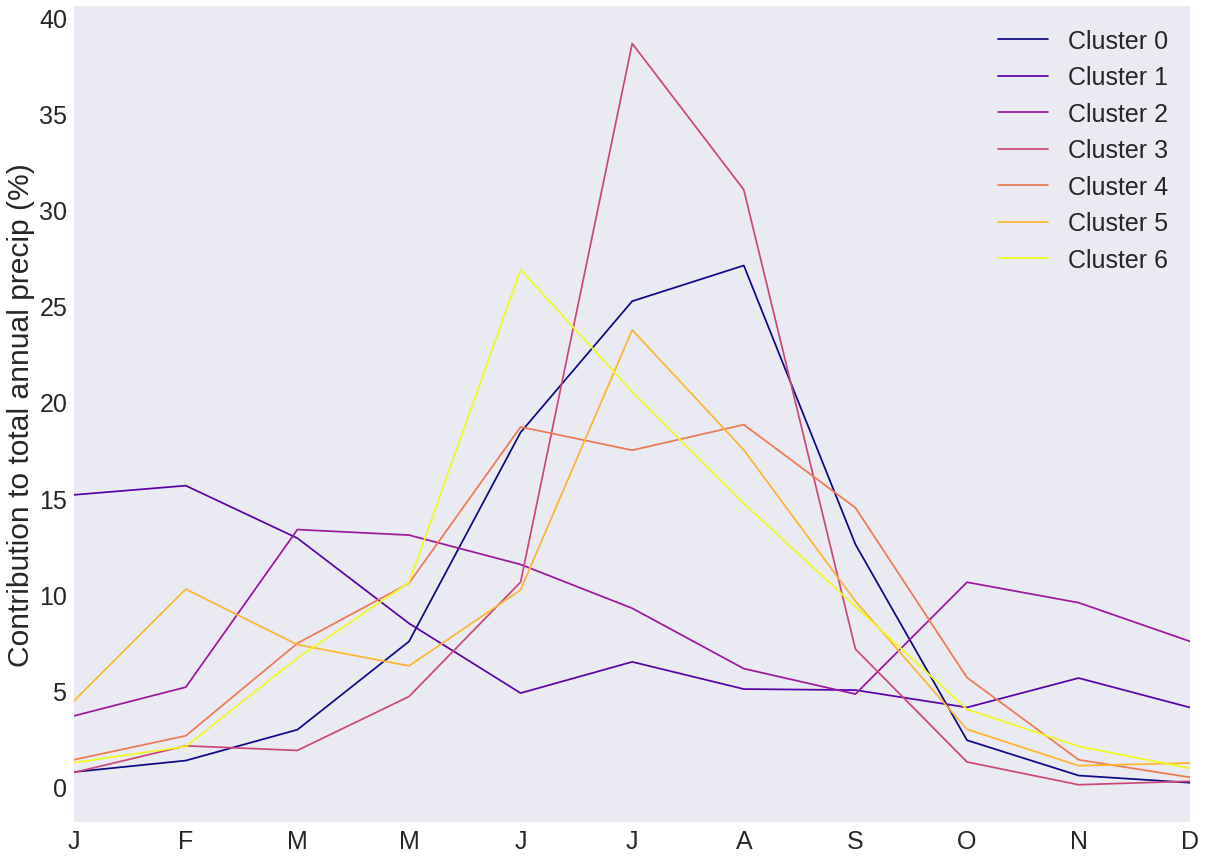

In [22]:
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 25,
                     'xtick.labelsize' : 25,
                     'ytick.labelsize' : 25})
plt.figure(figsize=(20, 15))
plt.ylabel('Contribution to total annual precip (%)', fontsize= 30)
labels= ['J', 'F', 'M','M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
plt.xticks(np.arange(1,12,1), labels)
plt.grid()
plt.xlim(1,11)


n = 7
colors = plt.cm.plasma(np.linspace(0,1,n))

for i in range(n):
    plt.plot(kmeans.cluster_centers_[i], label = 'Cluster '+ str(i) , color=colors[i])

         
         
plt.legend( prop={'size': 25})
#plt.show()
plt.rcParams.update({'font.size': 30})


plt.savefig('/media/juli/Elements/comparison/gpm_seasonal_cluster7.pdf')

In [77]:
# fast plot
#plt.imshow(cluster_grid)

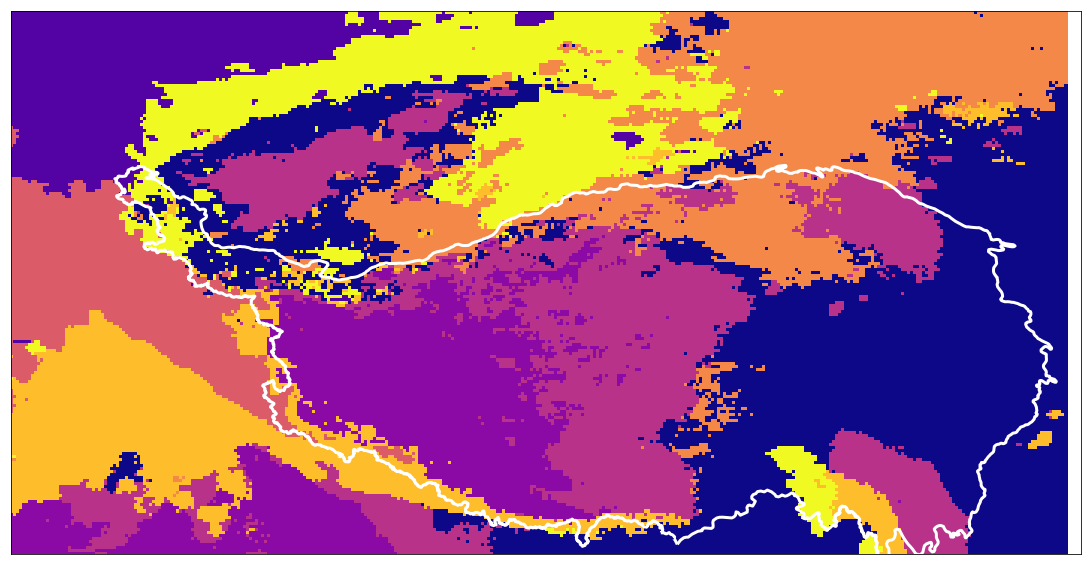

In [20]:
plt.figure(figsize=(20, 10))


cmap = plt.cm.get_cmap('plasma')
m = Basemap(projection='cyl', llcrnrlat=26.95, urcrnrlat= 44.95, llcrnrlon=70.05, urcrnrlon=105.5,  resolution = 'c')
lons, lats =np.meshgrid(lon, lat)
xi,yi = m(lons,lats)
cs = m.pcolormesh(xi,yi, cluster_grid.T, cmap = cmap) 


# Plot TP boundary polyline from shapefile 
shapefile='/media/juli/Data/master_thesis/Master_thesis/data/DBATP/DBATP'
TP_bound=m.readshapefile(shapefile, 'boundary', color='white', linewidth=3.0)

plt.savefig('/media/juli/Elements/comparison/cluster_seasonal_grid7_new.png')

- cluster analysis of seasonality indicate that pixels are more similar along west-east axis compared to north- south axis (different to Yao et al framework)
- two clusters are found which have opposite curve (with peaks in spring in autumn and summer depression), but these are outside of the plateau (from westerly direction)  

## check 

In [141]:
file = '/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/daily_files/GPM_IMERG_20170628_contr_to_day.nc4'
check, lon, lat = read_in_netcdf(file)


## Cluster analysis diurnal 

In [92]:
file = '/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/daily_files/gpm_imerg_cluster_input_diurnal.nc4'
precip, lon, lat = read_in_netcdf(file)

In [93]:
print(np.shape(precip_avg))


(8775, 181)


In [94]:
# calculate hourly instead of 30 min 
precip_avg= np.zeros((351,181))
i=0 
for idx, row in enumerate(precip[:,:]):
    if (i % 2) == 0:
        a = np.nanmean([row, precip[:,:][idx]], axis = 0)
        #print(idx, np.shape(a))
        precip_avg= np.concatenate((precip_avg, a),axis =0)
    i+=1


In [95]:
new = np.reshape(precip_avg,(25,351,181))
precip = new[1::,:,:]
np.shape(precip)

(24, 351, 181)

In [96]:
#convert 3D matrix to 2D input matrix with n_gridpoints x n_features
data= np.reshape(precip, (24,351*181))
data= data.transpose()

In [115]:
X = data # input matrix shape (n_samples, n_features)
k = 5
kmeans = KMeans(n_clusters= k, random_state=0).fit(X)

# attributes
centers = kmeans.cluster_centers_ # n_clusters x n_features
labels = kmeans.labels_ # contains the actual classes 
cluster_grid= np.reshape(kmeans.labels_, ((351,181)))


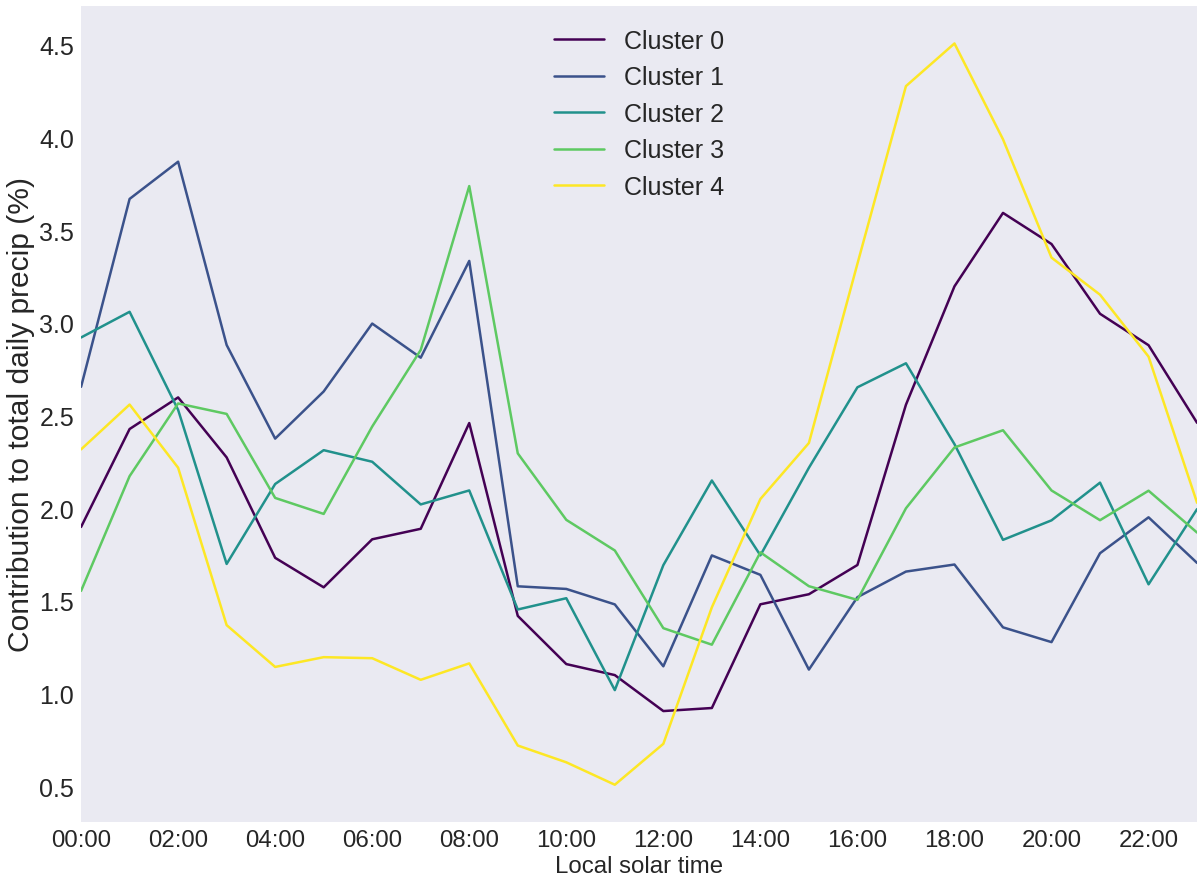

In [121]:
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 25,
                     'xtick.labelsize' : 25,
                     'ytick.labelsize' : 25})
plt.figure(figsize=(20, 15))
plt.ylabel('Contribution to total daily precip (%)', fontsize= 30)
plt.grid()

n = 5
colors = plt.cm.viridis(np.linspace(0,1,n))

for i in range(n):
    localtime=np.array(())
    localtime=np.append(localtime, centers[i, 16:24])
    localtime=np.append(localtime, centers[i, 0:16])
    plt.plot(localtime, label = 'Cluster '+ str(i) , color=colors[i], linewidth= 2.5)

plt.xlim(0,23)
plt.xlabel('Local solar time', fontsize= 24 )
labels=['00:00','02:00','04:00','06:00','08:00','10:00','12:00','14:00','16:00','18:00','20:00','22:00']
plt.xticks(np.linspace(0,22,12), labels,  fontsize=24)
         

plt.legend( prop={'size': 25})
#plt.show()
plt.rcParams.update({'font.size': 30})

plt.savefig('/media/juli/Elements/comparison/gpm_diurnal_cluster5.pdf')

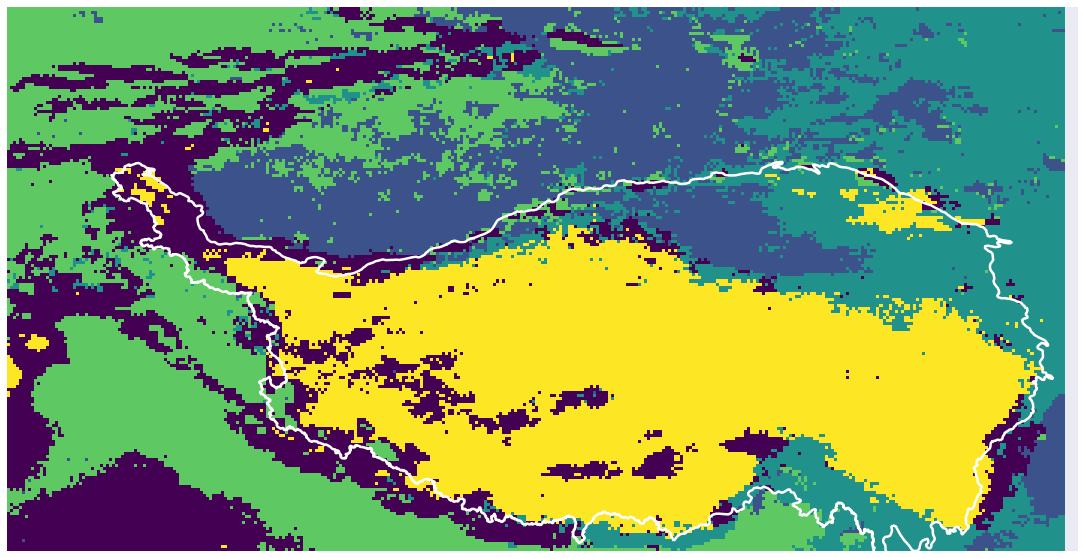

In [52]:
plt.figure(figsize=(20, 10))
cmap = plt.cm.get_cmap('viridis')
m = Basemap(projection='cyl', llcrnrlat=26.95, urcrnrlat= 44.95, llcrnrlon=70.05, urcrnrlon=105.5,  resolution = 'c')
lons, lats =np.meshgrid(lon, lat)
xi,yi = m(lons,lats)
cs = m.pcolormesh(xi,yi, cluster_grid.T, cmap = cmap) 


# Plot TP boundary polyline from shapefile 
shapefile='/media/juli/Data/master_thesis/Master_thesis/data/DBATP/DBATP'
TP_bound=m.readshapefile(shapefile, 'boundary', color='white', linewidth=2.5)

plt.savefig('/media/juli/Elements/comparison/cluster_diurnal_grid5.png')

## Getting optimal k (number of clusters) with elbow method

- mean distance of all data points to their centroid as a function of k 
- this will always decrease, but find elbow point

## Nr. of clusters for season

In [175]:
dis = np.array(())

for l in np.unique(labels):
    selected_rows = data[labels == l,:]
    for col in np.arange(0,12):
        m = np.absolute(np.subtract(selected_rows[:,col],centers[l,col]))
        dis = np.append(dis,m, axis = 0)

In [176]:
mean_distance = np.nanmean(dis)
mean_distance

2.3438313514551603

In [198]:
# test different k
k_variations = [1, 2,3,4,5,6,7,8,9,10, 11, 12, 13, 14, 15, 16, 17]
distances = [] 

for k in k_variations:
    print('calculating... mean distances to centroid for K = ', k)
    kmeans = KMeans(n_clusters= k, random_state=0).fit(X)
    centers = kmeans.cluster_centers_ 
    labels = kmeans.labels_
    dis = np.array(())

    for l in np.unique(labels):
        selected_rows = data[labels == l,:]
        for col in np.arange(0,12):
            m = np.absolute(np.subtract(selected_rows[:,col],centers[l,col]))
            dis = np.append(dis,m, axis = 0)
        mean = np.nanmean(dis)
    mean_distance = np.nanmean(mean)
    distances.append(mean_distance)

calculating... mean distances to centroid for K =  1
calculating... mean distances to centroid for K =  2
calculating... mean distances to centroid for K =  3
calculating... mean distances to centroid for K =  4
calculating... mean distances to centroid for K =  5
calculating... mean distances to centroid for K =  6
calculating... mean distances to centroid for K =  7
calculating... mean distances to centroid for K =  8
calculating... mean distances to centroid for K =  9
calculating... mean distances to centroid for K =  10
calculating... mean distances to centroid for K =  11
calculating... mean distances to centroid for K =  12
calculating... mean distances to centroid for K =  13
calculating... mean distances to centroid for K =  14
calculating... mean distances to centroid for K =  15
calculating... mean distances to centroid for K =  16
calculating... mean distances to centroid for K =  17


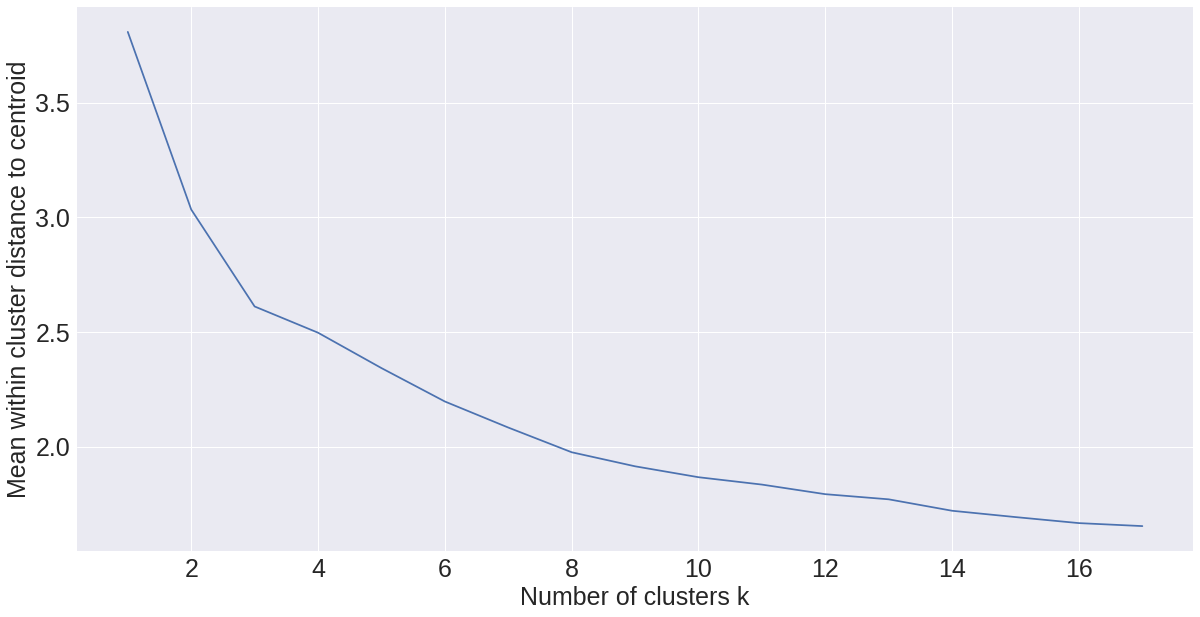

In [199]:
plt.figure(figsize=(20, 10))
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 25,
                     'xtick.labelsize' : 25,
                     'ytick.labelsize' : 25})

plt.plot(k_variations, distances)
plt.xlabel('Number of clusters k', fontsize = 25)
plt.ylabel('Mean within cluster distance to centroid', fontsize = 25)
plt.show()

## Nr. of clusters for diurnal curves

In [46]:
# test different k
k_variations = [1, 2,3,4,5,6,7,8,9,10, 11, 12, 13, 14, 15, 16, 17]
distances = [] 

for k in k_variations:
    print('calculating... mean distances to centroid for K = ', k)
    kmeans = KMeans(n_clusters= k, random_state=0).fit(X)
    centers = kmeans.cluster_centers_ 
    labels = kmeans.labels_
    dis = np.array(())

    for l in np.unique(labels):
        selected_rows = data[labels == l,:]
        for col in np.arange(0,12):
            m = np.absolute(np.subtract(selected_rows[:,col],centers[l,col]))
            dis = np.append(dis,m, axis = 0)
        mean = np.nanmean(dis)
    mean_distance = np.nanmean(mean)
    distances.append(mean_distance)

calculating... mean distances to centroid for K =  1
calculating... mean distances to centroid for K =  2
calculating... mean distances to centroid for K =  3
calculating... mean distances to centroid for K =  4
calculating... mean distances to centroid for K =  5
calculating... mean distances to centroid for K =  6
calculating... mean distances to centroid for K =  7
calculating... mean distances to centroid for K =  8
calculating... mean distances to centroid for K =  9
calculating... mean distances to centroid for K =  10
calculating... mean distances to centroid for K =  11
calculating... mean distances to centroid for K =  12
calculating... mean distances to centroid for K =  13
calculating... mean distances to centroid for K =  14
calculating... mean distances to centroid for K =  15
calculating... mean distances to centroid for K =  16
calculating... mean distances to centroid for K =  17


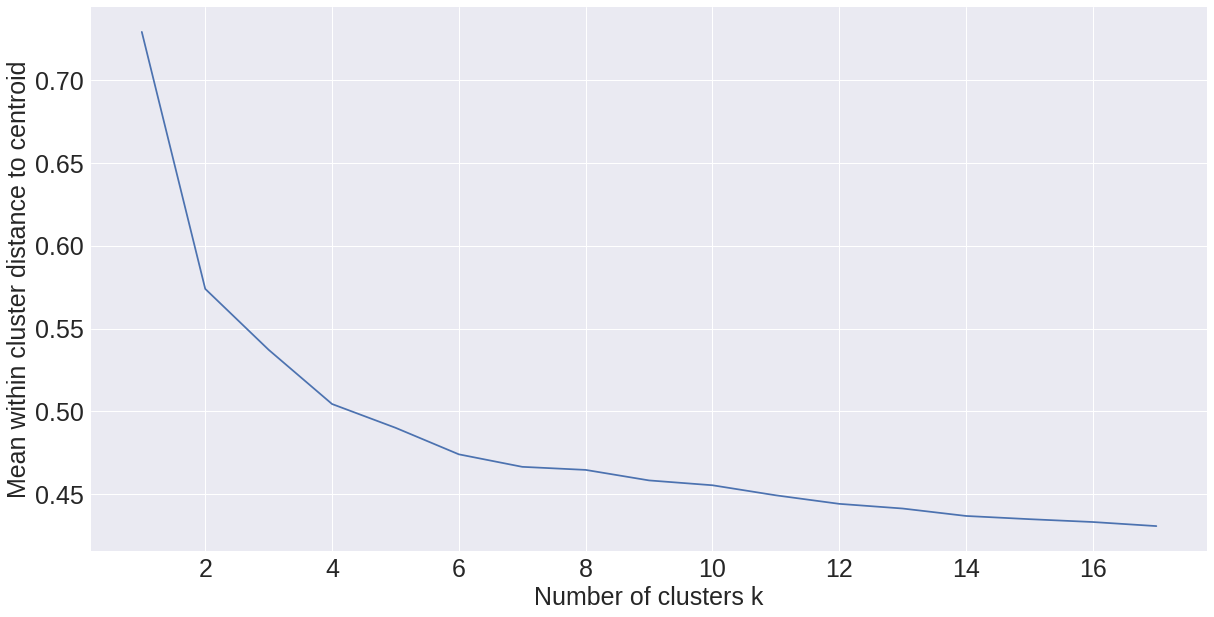

In [47]:
plt.figure(figsize=(20, 10))
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 25,
                     'xtick.labelsize' : 25,
                     'ytick.labelsize' : 25})

plt.plot(k_variations, distances)
plt.xlabel('Number of clusters k', fontsize = 25)
plt.ylabel('Mean within cluster distance to centroid', fontsize = 25)
plt.show()

# PCA of seasonal precip over the TP 

In [398]:
file = '/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/daily_files/GPM_IMERG_cluster_input_seasonal.nc4'
precip, lon, lat = read_in_netcdf(file)

In [399]:
from sklearn.decomposition import PCA

#convert 3D matrix to 2D input matrix with n_gridpoints x n_features
data= np.reshape(precip, (12,351*181))
data= data.transpose()
np.shape(data)
data

array([[0.79384077, 0.21038234, 1.3307225 , ..., 0.13289794, 0.11021849,
        0.5722426 ],
       [0.77806216, 0.26074788, 1.8938541 , ..., 0.08126032, 0.17184958,
        0.59550965],
       [0.78979546, 0.23071705, 2.0568836 , ..., 0.11541067, 0.17574455,
        0.5306247 ],
       ...,
       [0.        , 0.47892457, 2.4392016 , ..., 5.0511174 , 2.029569  ,
        0.        ],
       [0.        , 0.2629072 , 1.4889611 , ..., 4.665661  , 2.0556214 ,
        0.02769067],
       [0.        , 0.03552624, 1.7328318 , ..., 4.234447  , 1.2789446 ,
        0.0666117 ]], dtype=float32)

In [400]:
pca = PCA()
pca.fit(data)
comps= pca.components_
np.shape(comps)


(12, 12)

In [401]:
pca = PCA(n_components = 2)
new = pca.fit_transform(data)  
np.shape(new[:,0])
# reshape data space back to grid 
pca1= np.reshape(new[:,0], ((351,181)))
pca2= np.reshape(new[:,1], ((351,181)))

In [402]:
# normalize principal components 

from sklearn import preprocessing

pca1_norm = preprocessing.scale(pca1)
#pca1_norm = preprocessing.normalize(pca1, norm='l1')

/home/juli/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/juli/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


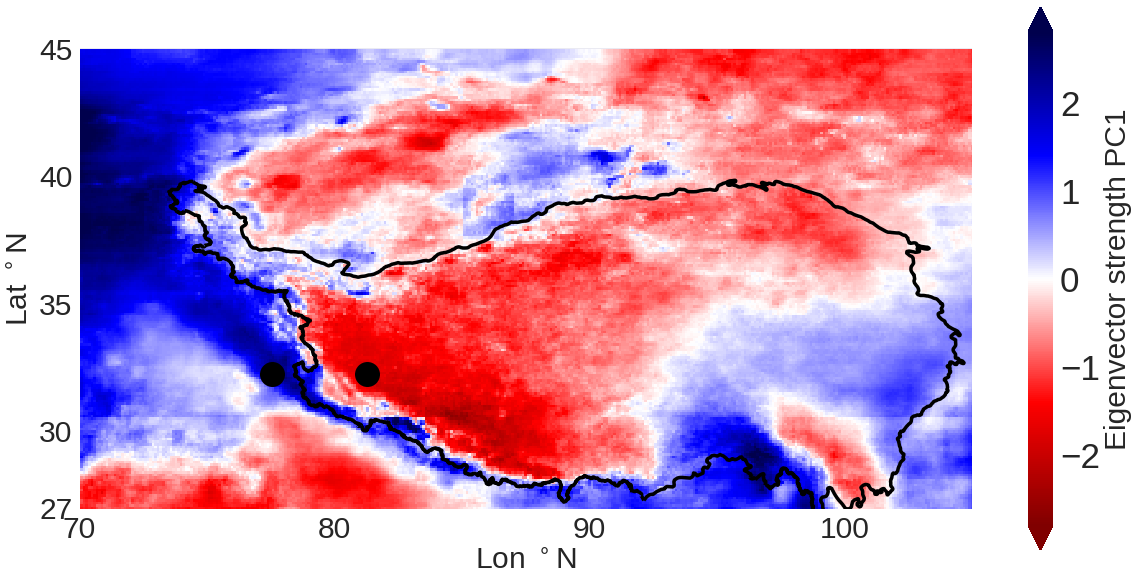

In [397]:
plt.figure(figsize=(20, 10))
cmap = plt.cm.get_cmap('seismic_r')
m = Basemap(projection='cyl', llcrnrlat=26.95, urcrnrlat= 44.95, llcrnrlon=70.05, urcrnrlon=105.0,  resolution = 'c')
lons, lats =np.meshgrid(lon, lat)
xi,yi = m(lons,lats)
Z=0 
cs = m.pcolormesh(xi,yi, pca1_norm.T, cmap = cmap, vmin= -2.8, vmax= 2.8) 


# Plot points with very different factors on map 
lo = 81.25
la = 32.25
x,y = m(lo, la)
m.plot(x, y, 'ko', markersize=25, label= 'A')

lo1 = 77.55
la1 = 32.25
x1,y1 = m(lo1, la1)
m.plot(x1, y1, 'ko', markersize=25, label= 'B')



# coordinate axes 
xlabels=[70, 80, 90, 100]
ylabels= [ 27, 30, 35, 40, 45]

plt.xticks([70, 80,90, 100], xlabels, fontsize=30)
plt.yticks([27,30, 35, 40, 45],ylabels, fontsize=30)
plt.xlabel('Lon $^\circ$N',  fontsize=30)
plt.ylabel('Lat $^\circ$N',  fontsize=30)


# Plot TP boundary polyline from shapefile 
shapefile='/media/juli/Data/master_thesis/Master_thesis/data/DBATP/DBATP'
TP_bound=m.readshapefile(shapefile, 'boundary', color='black', linewidth=3.5)

cbar = plt.colorbar(extend= 'both')
cbar.set_label('Eigenvector strength PC1', fontsize= 30)

plt.savefig('/media/juli/Elements/comparison/pc1_seasonal.png')

# reconstruction of seasonal curve (mean vector at specific point)

##  PCA_x  + mean * FACTOR (from map, pos or neg) 

In [341]:
# get indices for point coordinates, to know which factor to use for reconstruction 

neg= pca1[np.where(lon == lo),np.where(lat == la)].flatten()[0]
pos= pca1[np.where(lon == lo1),np.where(lat == la1)].flatten()[0]
print('factors', pos, neg )


factors 25.050858 -33.69229


/home/juli/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/juli/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


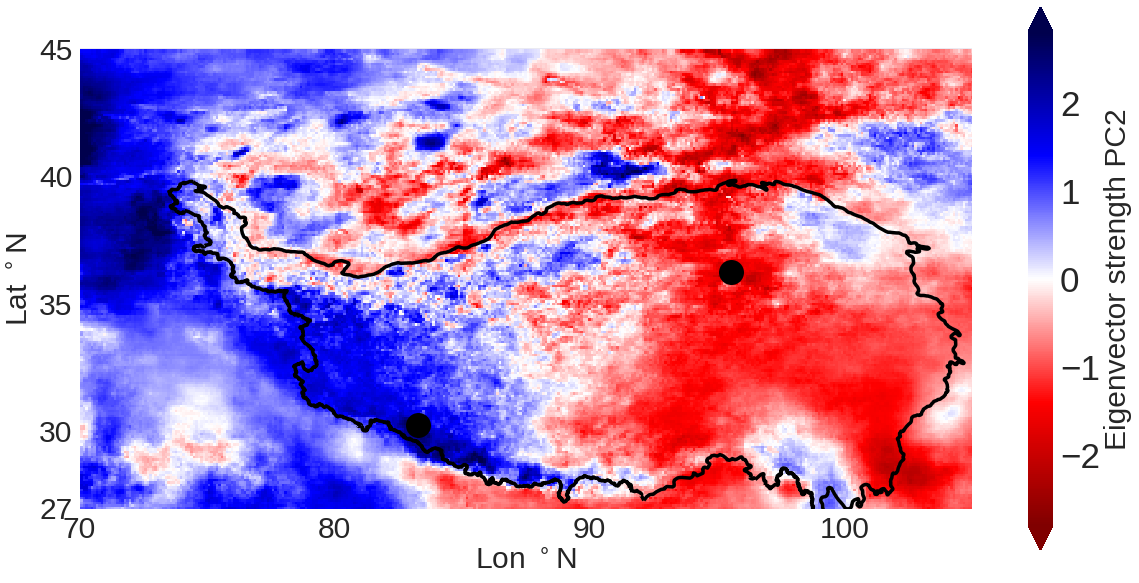

In [403]:
pca2= np.reshape(new[:,1], ((351,181)))
plt.figure(figsize=(20, 10))
cmap = plt.cm.get_cmap('seismic_r')
m = Basemap(projection='cyl', llcrnrlat=26.95, urcrnrlat= 44.95, llcrnrlon=70.05, urcrnrlon=105.0,  resolution = 'c')
lons, lats =np.meshgrid(lon, lat)
xi,yi = m(lons,lats)
cs = m.pcolormesh(xi,yi, preprocessing.scale(pca2).T, cmap = cmap, vmin = -2.8, vmax = 2.8) 
#cs = m.pcolormesh(xi,yi, pca2.T, cmap = cmap) 


cbar = plt.colorbar(extend= 'both')
cbar.set_label('Eigenvector strength PC2', fontsize= 30)

# coordinate axes 
xlabels=[70, 80, 90, 100]
ylabels= [ 27, 30, 35, 40, 45]

plt.xticks([70, 80,90, 100], xlabels, fontsize=30)
plt.yticks([27,30, 35, 40, 45],ylabels, fontsize=30)
plt.xlabel('Lon $^\circ$N',  fontsize=30)
plt.ylabel('Lat $^\circ$N',  fontsize=30)


# Plot points with very different factors on map 
# RED
lo = 83.25
la = 30.25
x,y = m(lo, la)
m.plot(x, y, 'ko', markersize=25, label= 'A')

# BLUE 
lo1 = 95.55
la1 = 36.25
x1,y1 = m(lo1, la1)
m.plot(x1, y1, 'ko', markersize=25, label= 'B')


# Plot TP boundary polyline from shapefile 
shapefile='/media/juli/Data/master_thesis/Master_thesis/data/DBATP/DBATP'
TP_bound=m.readshapefile(shapefile, 'boundary', color='black', linewidth=3.5)

plt.savefig('/media/juli/Elements/comparison/seasonal_pc2.png')

In [333]:
# attributes of PC instance 
comps= pca.components_ # direction of max variance, sorted by explained variance, shape = n components x n features 
var= pca.explained_variance_ratio_ # how much of the variance (%)is explained by each component (shape = n components)
pca.singular_values_ # shape = n_components 
means = pca.mean_ # shape = n_features 


In [334]:
var

array([0.52826726, 0.21775094], dtype=float32)

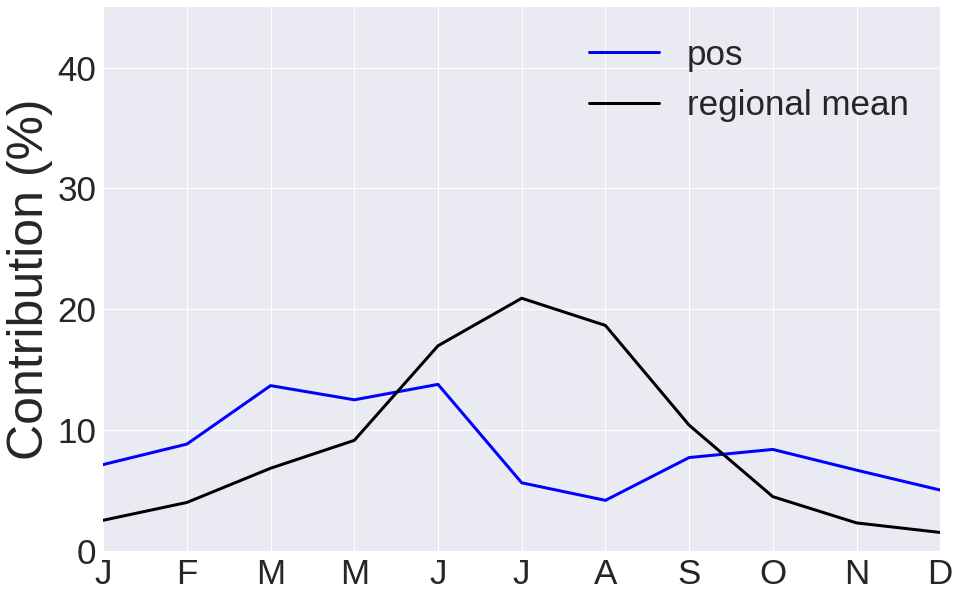

In [325]:

# Reconstruction of seasonal curves, PCA 1 

plt.style.use('seaborn')
plt.rcParams.update({'font.size': 35,
                     'xtick.labelsize' : 35,
                     'ytick.labelsize' : 35})
plt.figure(figsize=(15, 10))


plt.plot(means + pos * comps[0],  color= 'b', label = "pos", linewidth= 3.0 )
plt.plot(means,  color= 'k', label = 'regional mean', linewidth= 3.0 )


plt.ylabel('Contribution (%)', fontsize= 50)
labels= ['J', 'F', 'M','M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
plt.xticks(np.arange(1,12,1), labels)
plt.xlim(1,11)
plt.ylim(0,45)

plt.legend( prop={'size': 35})
#plt.figure()

plt.savefig('/media/juli/Elements/comparison/reconstructed_pca1_seasonal_pos.png')


In [322]:
neg

-33.69231

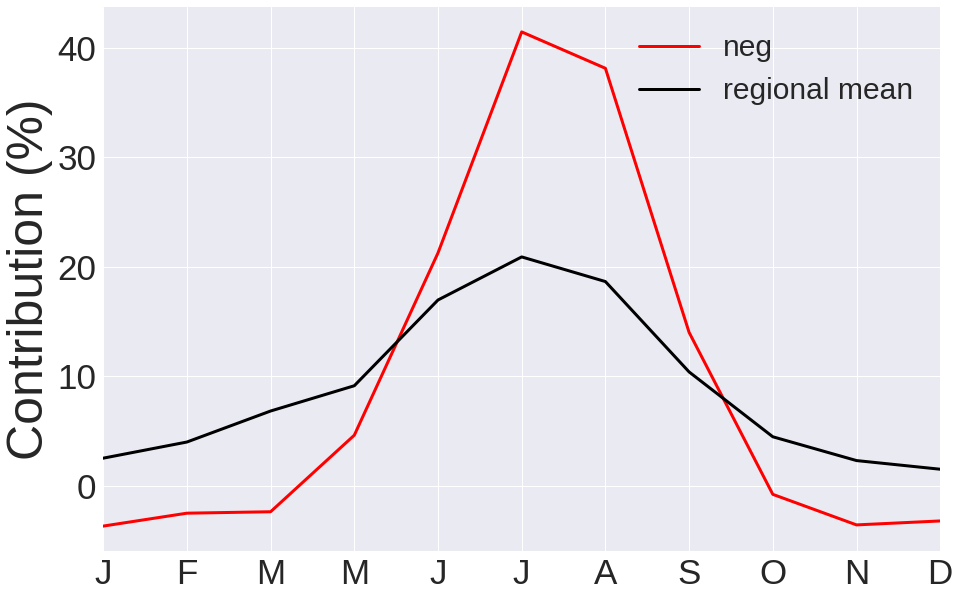

In [324]:
# Reconstruction of seasonal curves, PCA 1 

plt.style.use('seaborn')
plt.rcParams.update({'font.size': 35,
                     'xtick.labelsize' : 35,
                     'ytick.labelsize' : 35})
plt.figure(figsize=(15, 10))


plt.plot(means + neg * comps[0], color= 'r', label = "neg" , linewidth= 3.0 )
plt.plot(means, color = 'k', label = 'regional mean', linewidth= 3.0 )


plt.ylabel('Contribution (%)', fontsize= 50)
labels= ['J', 'F', 'M','M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
plt.xticks(np.arange(1,12,1), labels)
plt.xlim(1,11)

plt.legend( prop={'size': 30})
#plt.figure()

plt.savefig('/media/juli/Elements/comparison/reconstructed_pca1_seasonal_neg.png')

In [328]:
var

array([5.2826732e-01, 2.1775112e-01, 7.7774577e-02, 5.9207741e-02,
       4.7803171e-02, 2.0826597e-02, 1.6467812e-02, 1.1979606e-02,
       9.6004661e-03, 6.6614631e-03, 3.6601895e-03, 4.1010591e-15],
      dtype=float32)

In [348]:
# get indices for point coordinates, to know which factor to use for reconstruction 

neg= pca2[np.where(lon == lo),np.where(lat == la)].flatten()[0]
pos= pca2[np.where(lon == lo1),np.where(lat == la1)].flatten()[0]
print('factors', pos, neg )

factors -14.259894 24.721344


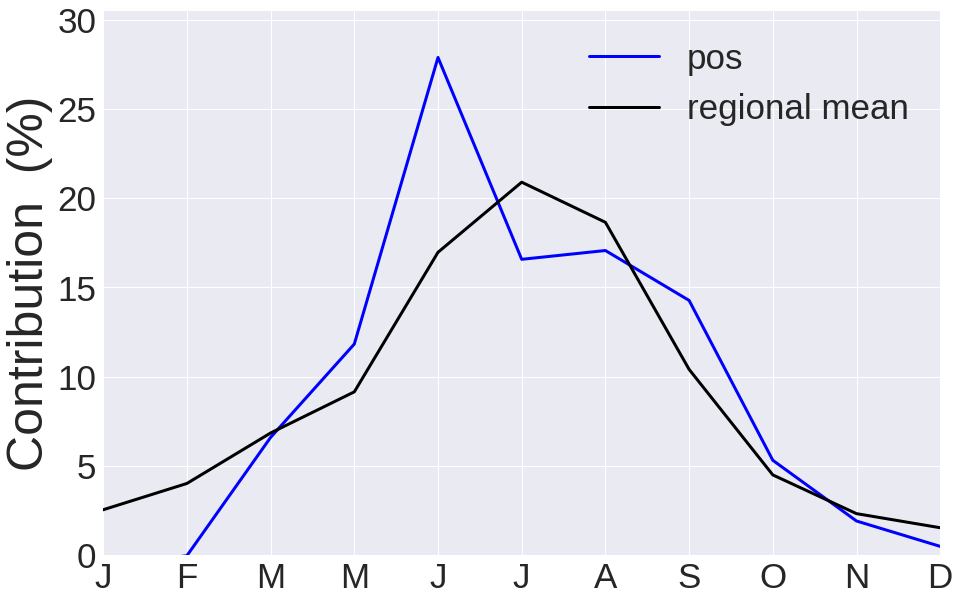

In [349]:
# Reconstruction of seasonal curves, PCA 2 

plt.style.use('seaborn')
plt.rcParams.update({'font.size': 35,
                     'xtick.labelsize' : 35,
                     'ytick.labelsize' : 35})
plt.figure(figsize=(15, 10))


plt.plot(means + pos * comps[1], color= 'b', label = "pos", linewidth= 3.0 )
plt.plot(means,color= 'k',  label = 'regional mean', linewidth= 3.0 )
plt.legend( prop={'size': 35})

plt.ylabel('Contribution  (%)', fontsize= 50)
labels= ['J', 'F', 'M','M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
plt.xticks(np.arange(1,12,1), labels)
plt.xlim(1,11)
plt.ylim(0,30.5)

#plt.figure()

plt.savefig('/media/juli/Elements/comparison/reconstructed_pca2_seasonal_pos.png')

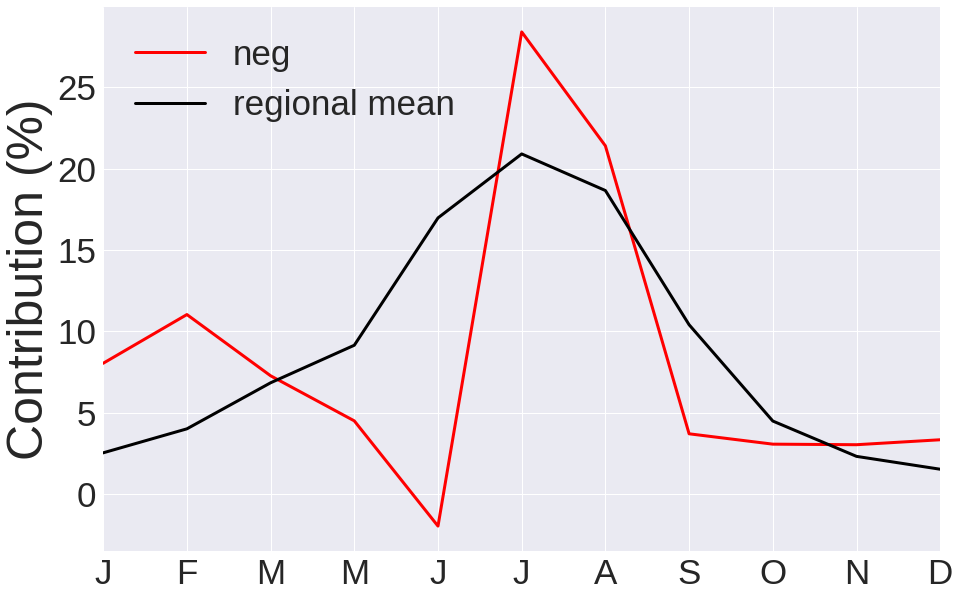

In [350]:
# Reconstruction of seasonal curves, PCA 2 

plt.style.use('seaborn')
plt.rcParams.update({'font.size': 35,
                     'xtick.labelsize' : 35,
                     'ytick.labelsize' : 35})
plt.figure(figsize=(15, 10))


plt.plot(means + neg * comps[1], color= 'r', label = "neg", linewidth= 3.0 )
plt.plot(means,color= 'k',  label = 'regional mean', linewidth= 3.0 )
plt.legend( prop={'size': 35})

plt.ylabel('Contribution (%)', fontsize= 50)
labels= ['J', 'F', 'M','M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
plt.xticks(np.arange(1,12,1), labels)
plt.xlim(1,11)

#plt.figure()

plt.savefig('/media/juli/Elements/comparison/reconstructed_pca2_seasonal_neg.png')


# PCA heatmap - looking for clusters 

## plot histogram of PCA1 vs. PCA2 to see whether clusters appear

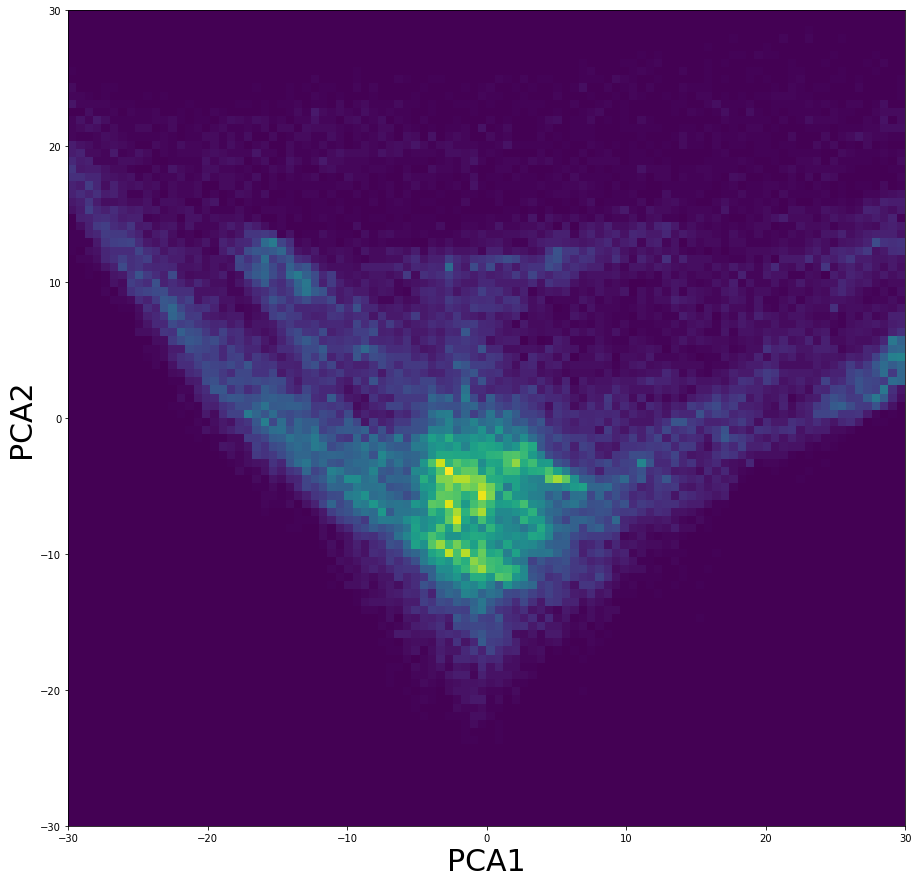

In [20]:
plt.figure(figsize = ((15,15)))

pca1= pca1.flatten()
pca2= pca2.flatten()
plt.hist2d(pca1, pca2, bins = np.linspace(-30, 30, 101) )
plt.xlabel('PCA1', fontsize= '30')
plt.ylabel('PCA2', fontsize= '30')
plt.show()

## no real clusters visible! 

In [244]:
cov = pca.get_covariance()


(12, 12)

 - domain dependency  is rather a problem from time series analysis 
 - eigenvectors* PC + mean to reconstruct curve 
 - PC show deviation from mean curve 
 - PCA heatmap, plot PCA1 and PCA2 against each other and their frequencies in order to see whether you can find any clusters (see above) 

 

## PCA diurnal

In [405]:
file = '/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/daily_files/GPM_IMERG_cluster_input_diurnal.nc4'
precip, lon, lat = read_in_netcdf(file)

In [406]:
precip= precip*100 
np.shape(precip)

(48, 351, 181)

In [407]:
np.sum(precip, axis =0 )

array([[100.      ,  99.999985, 100.00001 , ..., 100.22124 , 100.21473 ,
        100.197914],
       [100.      , 100.00001 , 100.00001 , ..., 100.30356 , 100.24058 ,
        100.17726 ],
       [100.      ,  99.99999 , 100.      , ..., 100.313675, 100.25072 ,
        100.20226 ],
       ...,
       [100.00001 , 100.000015,  99.99999 , ..., 100.      ,  99.99999 ,
        100.00001 ],
       [100.      , 100.      ,  99.99999 , ..., 100.      , 100.00001 ,
         99.99999 ],
       [ 99.99999 , 100.      , 100.00001 , ...,  99.99999 , 100.      ,
        100.      ]], dtype=float32)

In [360]:
# calculate hourly instead of 30 min 
precip_avg= np.zeros((351,181))
i=0 
for idx, row in enumerate(precip[:,:]):
    if (i % 2) == 0:
        a = np.nansum([row, precip[:,:][idx]], axis = 0)
        #print(idx, np.shape(a))
        precip_avg= np.concatenate((precip_avg, a),axis =0)
    i+=1


In [361]:
new = np.reshape(precip_avg,(25,351,181))
precip = new[1::,:,:]
np.shape(precip)

(24, 351, 181)

In [362]:
np.sum(precip[:,1,1])

10440.866882324219

In [408]:
#convert 3D matrix to 2D input matrix with n_gridpoints x n_features
data= np.reshape(precip, (48,351*181))
data= data.transpose()
np.shape(data)
data

array([[1.7315881, 0.6381638, 0.6032072, ..., 1.9494699, 0.9634346,
        1.5410388],
       [1.2773119, 1.0104909, 1.3434569, ..., 2.7379134, 2.5855045,
        1.554193 ],
       [2.256909 , 2.6708224, 0.8305953, ..., 3.3283904, 2.4902952,
        1.792776 ],
       ...,
       [1.9090999, 1.3527908, 1.002039 , ..., 4.2102904, 2.3014097,
        1.0349253],
       [1.5303426, 1.6437554, 1.3442181, ..., 3.7466989, 1.6049285,
        1.3740581],
       [2.4739363, 1.6342236, 1.8900801, ..., 3.3367317, 1.7379988,
        2.1337004]], dtype=float32)

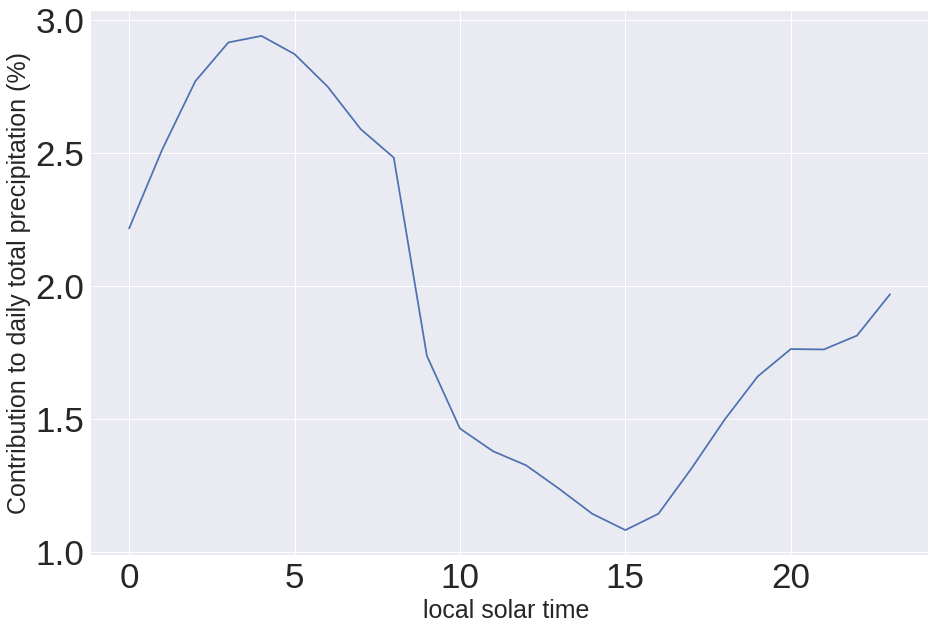

In [409]:
## mean curve 
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 35,
                     'xtick.labelsize' : 35,
                     'ytick.labelsize' : 35})
plt.figure(figsize=(15, 10))


mean = np.nanmean(precip, axis=(1, 2))
localtime=np.array(())
localtime=np.append(localtime, mean[16:24])
localtime=np.append(localtime, mean[0:16])
plt.ylabel('Contribution to daily total precipitation (%)', fontsize = 25)
plt.xlabel('local solar time ', fontsize = 25)
plt.plot(localtime)
plt.show()


In [424]:
#pca = PCA()
#pca.fit(data)
#comps= pca.components_
#np.shape(comps)


pca = PCA(n_components = 2)
new = pca.fit_transform(data)  
np.shape(new[:,0])
# reshape data space back to grid 
pca1= np.reshape(new[:,0], ((351,181)))
pca2= np.reshape(new[:,1], ((351,181)))

/home/juli/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/juli/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


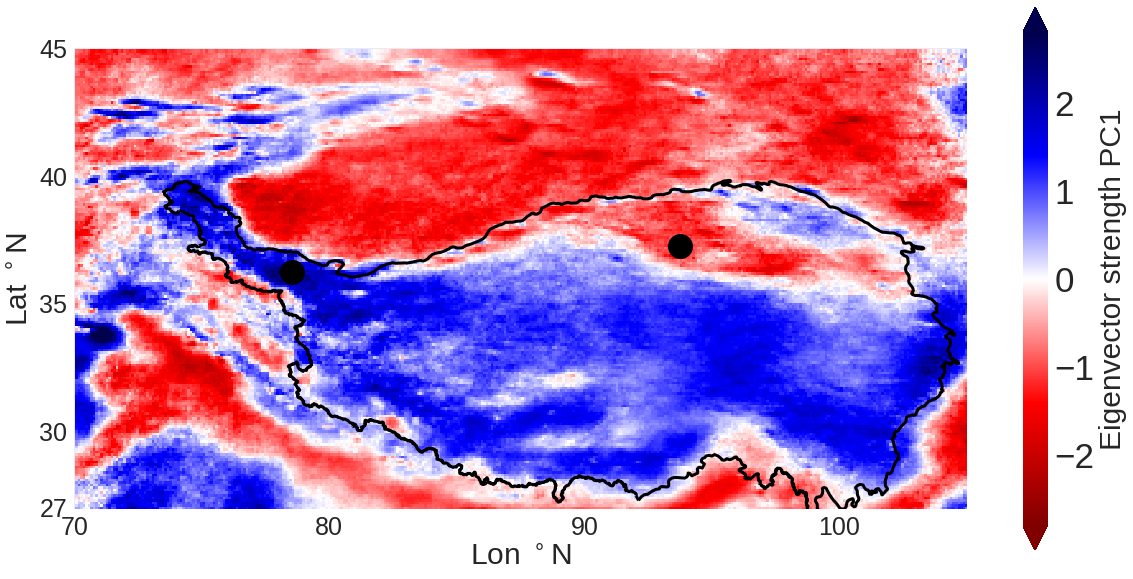

In [437]:
# grid plot
plt.figure(figsize=(20, 10))


cmap = plt.cm.get_cmap('seismic_r')
m = Basemap(projection='cyl', llcrnrlat=26.95, urcrnrlat= 44.95, llcrnrlon=70.05, urcrnrlon=105.0,  resolution = 'c')
lons, lats =np.meshgrid(lon, lat)
xi,yi = m(lons,lats)
cs = m.pcolormesh(xi,yi,  preprocessing.scale(pca1.T) , cmap = cmap,  vmin = -2.8, vmax = 2.8)
#s = m.pcolormesh(xi,yi,  pca1.T , cmap = cmap )


# coordinate axes 

xlabels=[70, 80, 90, 100]
ylabels= [ 27, 30, 35, 40, 45]

plt.xticks([70, 80,90, 100], xlabels, fontsize=25)
plt.yticks([27,30, 35, 40, 45],ylabels, fontsize=25)
plt.xlabel('Lon $^\circ$N',  fontsize=30)
plt.ylabel('Lat $^\circ$N',  fontsize=30)


# Plot points with very different factors on map 
# BLUE
lo = 78.55
la = 36.25
x,y = m(lo, la)
m.plot(x, y, 'ko', markersize=25, label= 'A')


# RED 
lo1 = 93.75
la1 = 37.25
x1,y1 = m(lo1, la1)
m.plot(x1, y1, 'ko', markersize=25, label= 'B')



cbar = plt.colorbar(extend= 'both')
cbar.set_label('Eigenvector strength PC1' , fontsize= 30)
                     
               
# Plot TP boundary polyline from shapefile 
shapefile='/media/juli/Data/master_thesis/Master_thesis/data/DBATP/DBATP'
TP_bound=m.readshapefile(shapefile, 'boundary', color='black', linewidth=3.0)

plt.savefig('/media/juli/Elements/comparison/diurnal_pc1.png')

In [438]:
# get indices for point coordinates, to know which factor to use for reconstruction 

pos= pca1[np.where(lon == lo),np.where(lat == la)].flatten()[0]
neg= pca1[np.where(lon == lo1),np.where(lat == la1)].flatten()[0]
print('factors', pos, neg )

factors 6.356885 -5.8717713


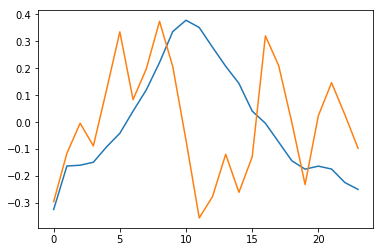

In [37]:
comps= pca.components_
plt.plot(comps[0])
plt.plot(comps[1])

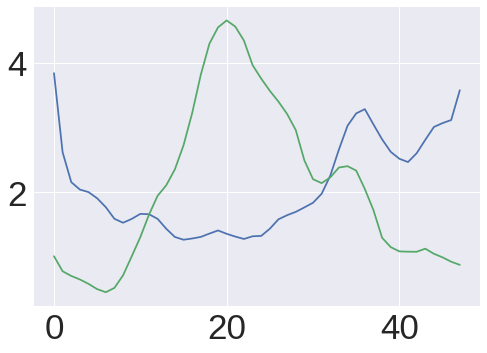

In [444]:
plt.plot(pca.mean_ + pca.components_[0] * neg)
plt.plot(pca.mean_ + pca.components_[0] * pos)

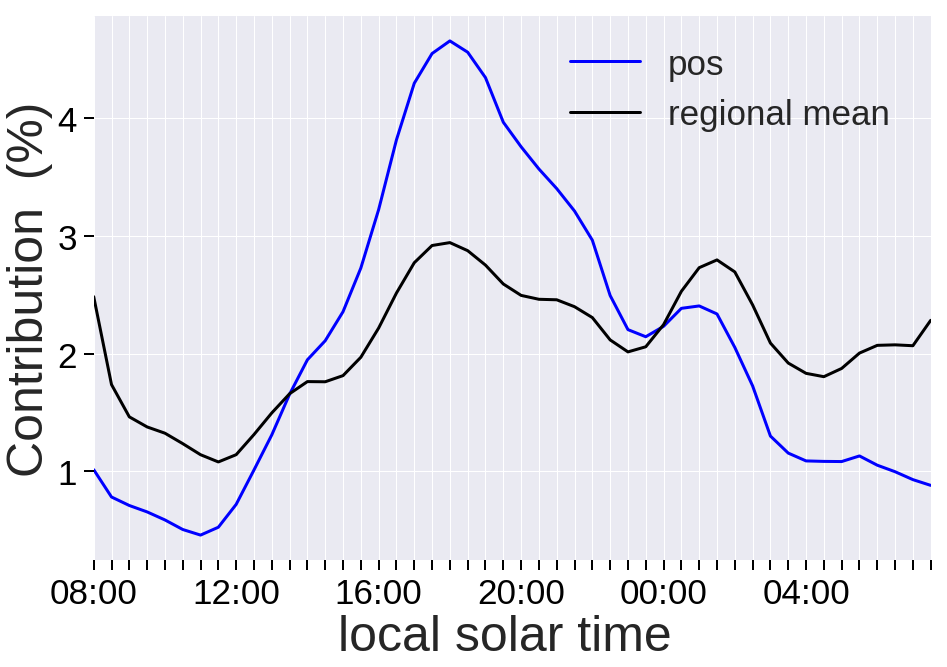

In [493]:
# reconstructed mean curves 
## mean curve 
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 35,
                     'xtick.labelsize' : 35,
                     'ytick.labelsize' : 35})
plt.figure(figsize=(15, 10))



mean = pca.mean_ + pca.components_[0] * pos
localtime=np.array(())
localtime=np.append(localtime, mean[16:24])
localtime=np.append(localtime, mean[0:16])
plt.ylabel('Contribution  (%)', fontsize = 50)
plt.xlabel('local solar time ', fontsize = 50)
plt.plot(mean, color= 'b',  linewidth = 3.0, label = 'pos')
plt.plot(pca.mean_, color= 'k', linewidth= 3.0, label = 'regional mean ')

plt.xlim(0,47)
plt.xticks(np.arange(48), ['08:00','', '','', '', '', '','', '12:00','', '','', '','', '','', '16:00','', '','', '','', '','', '20:00','', '','', '','', '','', '00:00','', '','', '','', '','', '04:00','', '','', '', ''])
plt.tick_params(direction='out', length=10, width=2, colors='k')


plt.legend( prop={'size': 35})


plt.savefig('/media/juli/Elements/comparison/pca1_diurnal_pos.png')

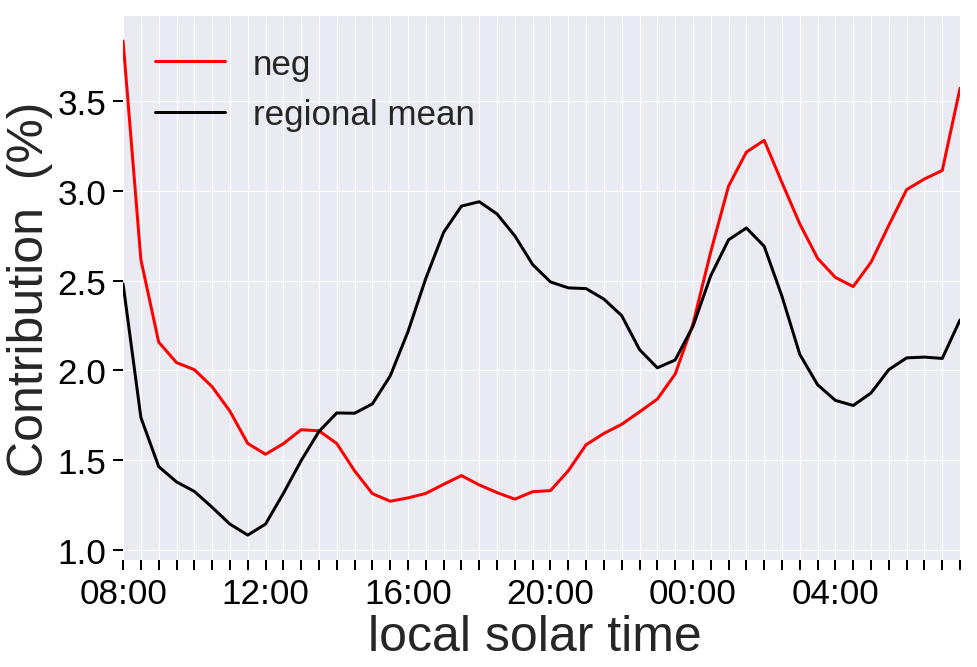

In [516]:
# reconstructed mean curves 

## mean curve 
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 35,
                     'xtick.labelsize' : 35,
                     'ytick.labelsize' : 35})
plt.figure(figsize=(15, 10))

mean = pca.mean_ + pca.components_[0] * neg
localtime=np.array(())
localtime=np.append(localtime, mean[16:24])
localtime=np.append(localtime, mean[0:16])
plt.ylabel('Contribution  (%)', fontsize = 50)
plt.xlabel('local solar time ', fontsize = 50)
plt.plot(mean, color= 'r', linewidth = 3.0, label= 'neg')
plt.plot(pca.mean_, color= 'k', linewidth= 3.0, label= 'regional mean')

plt.xlim(0,47)
plt.xticks(np.arange(48), ['08:00','', '','', '', '', '','', '12:00','', '','', '','', '','', '16:00','', '','', '','', '','', '20:00','', '','', '','', '','', '00:00','', '','', '','', '','', '04:00','', '','', '', ''])
plt.tick_params(direction='out', length=10, width=2, colors='k')

plt.legend( prop={'size': 35})


plt.savefig('/media/juli/Elements/comparison/pca1_diurnal_neg.png')

In [496]:
def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = str(100 * y)

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'


/home/juli/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


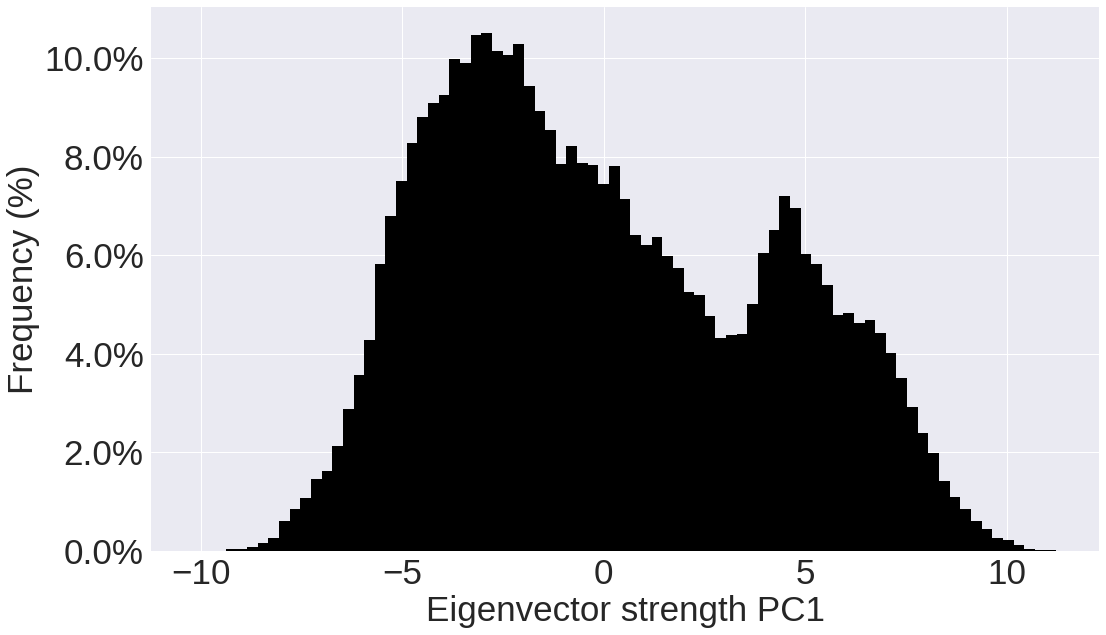

In [513]:
# Histogram of PCA1 diurnal normalized 
import matplotlib
from matplotlib.ticker import FuncFormatter


## mean curve 
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 35,
                     'xtick.labelsize' : 35,
                     'ytick.labelsize' : 35})
plt.figure(figsize=(17, 10))

plt.hist(pca1.flatten(), bins= 81, color= 'k', normed = True)


# Create the formatter using the function to_percent. This multiplies all the
# default labels by 100, making them all percentages
formatter = FuncFormatter(to_percent)

# Set the formatter
plt.gca().yaxis.set_major_formatter(formatter)


plt.ylabel('Frequency (%)', fontsize= 35)
plt.xlabel('Eigenvector strength PC1', fontsize = 35)
plt.savefig('/media/juli/Elements/comparison/pca1_hist.png')


# maybe clusters! bimodal distr.

In [396]:
# explained variance of PCs

var

array([0.52826726, 0.21775094], dtype=float32)

In [41]:
# attributes of instance 
comps= pca.components_ # direction of max variance, sorted by explained variance, shape = n components x n features 
var= pca.explained_variance_ratio_ # how much of the variance (%)is explained by each component (shape = n components)
pca.singular_values_ # shape = n_components 
means = pca.mean_ # shape = n_features 


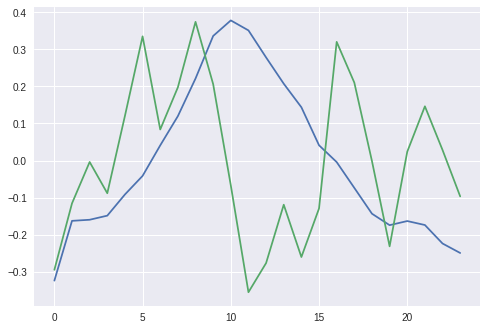

In [231]:
# plot components 

comp1=np.array(())
comp1=np.append(comp1, comps[0, 32:48])
comp1=np.append(comp1, comps[0, 0:32])


comp2=np.array(())
comp2=np.append(comp2, comps[1, 32:48])
comp2=np.append(comp2, comps[1, 0:32])


plt.plot(comp1)
plt.plot(comp2)



#plt.plot(comp1+localtime)
#plt.plot(comp2+localtime)
plt.show()

In [19]:
#import eofs # another package, library for meteorological data

- solve package inconsistencies